In [2]:
import os
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr

In [3]:
parent = os.path.join(Path(os.getcwd()).parent)

print(parent)

sys.path.append(parent)

c:\Users\bruij_kn\OneDrive - Stichting Deltares\Documents\GitHub\thermo-morphological-model


In [4]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

In [6]:
# reference variables
per_sa = {
    "start_time": pd.to_datetime("2018-01-01"), # these dates are relevant for the bluff edge only
    "end_time": pd.to_datetime("2019-01-01"),
}

I need:
- I need to extract total erosion of each variable, and check against baseline
- A way to differentiate between different types of tested variables

==> pd.DataFrame with columns for runid, sensitivity analysis level, sublevel, total erosion, and total erosion over baseline erosion.

In [44]:
# load overview dataframe
fpath_overview = Path("overview_sa.csv")
df = pd.read_csv(fpath_overview)

# get values for base run
fpath_base = Path("erosion_rates/sa_base.csv")
df_base = pd.read_csv(fpath_base, parse_dates=['time'])

x_start_base = df_base['x_bluff_edge'].values[0]
x_end_base = df_base['x_bluff_edge'].values[-1]
total_bluff_erosion_base = x_end_base - x_start_base

# initialize erosion
total_erosion = []
rnte = [] # relative normalized total erosion

# loop through all parameters
for i, row in df.iterrows():
    runid_low = row['run_id_low']
    runid_high = row['run_id_high']
    
    try:
        df_low = pd.read_csv(Path(f'erosion_rates/{runid_low}.csv'), parse_dates=['time'])
        df_high = pd.read_csv(Path(f'erosion_rates/{runid_high}.csv'), parse_dates=['time'])

        x_start_low = df_low['x_bluff_edge'].values[0]
        x_start_high = df_high['x_bluff_edge'].values[0]
        
        x_end_low = df_low['x_bluff_edge'].values[-1]
        x_end_high = df_high['x_bluff_edge'].values[-1]
        
        total_erosion_low = x_end_low - x_start_low
        total_erosion_high = x_end_high - x_start_high
        
        rnte_low = total_erosion_low / total_bluff_erosion_base
        rnte_high = total_erosion_high / total_bluff_erosion_base
        
        total_erosion.append((total_erosion_low, total_erosion_high))
        rnte.append((rnte_low, rnte_high))
    
    except FileNotFoundError:
        total_erosion.append((0, 0))
        rnte.append((0, 0))

    
# add new columns
total_erosion = np.array(total_erosion)
rnte = np.array(rnte)

df['total_erosion_low[m]'] = total_erosion[:,0]
df['total_erosion_high[m]'] = total_erosion[:,1]

df['rnte_low[-]'] = rnte[:,0]
df['rnte_high[-]'] = rnte[:,1]

df.dropna(inplace=True, axis=0)

# df

In [35]:
df_volume_changes = pd.read_csv("volume_changes.csv")

# df_volume_changes

,Unnamed: 0,runid,V_start[m2],V_end[m2],dV[m2]
0,0,sa_base,1379.25,1329.504014,-49.745986
1,1,sa_base_alt,1379.25,1329.787953,-49.462047
2,2,sa_lvl1_1,1127.25,1086.681790,-40.568210
3,3,sa_lvl1_2,1631.25,1572.357972,-58.892028
4,4,sa_lvl1_3,1398.55,1376.469881,-22.080119
...,...,...,...,...,...
85,85,sa_lvl2_16,1379.25,1327.126475,-52.123525
86,86,sa_lvl2_17,1379.25,1329.373634,-49.876366
87,87,sa_lvl2_18,1379.25,1329.510277,-49.739723
88,88,sa_lvl3_1,1379.25,1328.562453,-50.687547


In [45]:
volume_change_base = df_volume_changes[df_volume_changes.runid=='sa_base']['dV[m2]'].values[0]

volume_start_low = []
volume_end_low = []
volume_change_low = []

volume_start_high = []
volume_end_high = []
volume_change_high = []

for runid in df.run_id_low.values:
    volume_start_low.append(df_volume_changes[df_volume_changes.runid==runid]['V_start[m2]'].values[0])
    volume_end_low.append(df_volume_changes[df_volume_changes.runid==runid]['V_end[m2]'].values[0])
    volume_change_low.append(df_volume_changes[df_volume_changes.runid==runid]['dV[m2]'].values[0])
    
for runid in df.run_id_high.values:
    volume_start_high.append(df_volume_changes[df_volume_changes.runid==runid]['V_start[m2]'].values[0])
    volume_end_high.append(df_volume_changes[df_volume_changes.runid==runid]['V_end[m2]'].values[0])
    volume_change_high.append(df_volume_changes[df_volume_changes.runid==runid]['dV[m2]'].values[0])
    
df['volume_start_low[m2]'] = volume_start_low
df['volume_end_low[m2]'] = volume_end_low
df['volume_change_low[m2]'] = volume_change_low

df['volume_start_high[m2]'] = volume_start_high
df['volume_end_high[m2]'] = volume_end_high
df['volume_change_high[m2]'] = volume_change_high

In [46]:
# display(df)
display(df.tail())

print(len(df))

,varied_parameter,level,sublevel,number_low,number_high,baseline_value,unit,variation,new_value_low,new_value_high,...,total_erosion_low[m],total_erosion_high[m],rnte_low[-],rnte_high[-],volume_start_low[m2],volume_end_low[m2],volume_change_low[m2],volume_start_high[m2],volume_end_high[m2],volume_change_high[m2]
40,Sea temperature*,2.0,thermodynamics,13.0,14.0,0.0,-,+-2,-2,+2,...,4.0,4.0,1.0,1.0,1379.25,1329.486770,-49.763230,1379.25,1327.762577,-51.487423
41,2m air temperature*,2.0,thermodynamics,15.0,16.0,0.0,-,+-2,-2,+2,...,4.0,4.0,1.0,1.0,1379.25,1351.533047,-27.716953,1379.25,1327.126475,-52.123525
42,Latent heat flux,2.0,thermodynamics,17.0,18.0,1.0,-,+-10%,*0.9,*1.1,...,4.0,4.0,1.0,1.0,1379.25,1329.373634,-49.876366,1379.25,1329.510277,-49.739723
43,Thermal module,3.0,thermal-module,1.0,1.0,1.0,-,-1,0,0,...,0.0,0.0,0.0,0.0,1379.25,1328.562453,-50.687547,1379.25,1328.562453,-50.687547
44,Solar flux calcuator,3.0,thermal-module,2.0,2.0,1.0,-,-1,0,0,...,4.0,4.0,1.0,1.0,1379.25,1328.566210,-50.683790,1379.25,1328.566210,-50.683790


45


In [47]:
# order dataframe from low to high (choose between which parameter I want to order)
df['erosion_diff[m]'] = np.abs(df['total_erosion_high[m]'].values - df['total_erosion_low[m]'].values)
df['volume_change_diff[m2]'] = np.abs(df['volume_change_high[m2]'].values - df['volume_change_low[m2]'].values)

df = df.sort_values('volume_change_diff[m2]')

In [50]:
display(df.head())
display(df.tail())

,varied_parameter,level,sublevel,number_low,number_high,baseline_value,unit,variation,new_value_low,new_value_high,...,rnte_low[-],rnte_high[-],volume_start_low[m2],volume_end_low[m2],volume_change_low[m2],volume_start_high[m2],volume_end_high[m2],volume_change_high[m2],erosion_diff[m],volume_change_diff[m2]
43,Thermal module,3.0,thermal-module,1.0,1.0,1.0,-,-1,0,0,...,0.0,0.0,1379.25,1328.562453,-50.687547,1379.25,1328.562453,-50.687547,0.0,0.000000
44,Solar flux calcuator,3.0,thermal-module,2.0,2.0,1.0,-,-1,0,0,...,1.0,1.0,1379.25,1328.566210,-50.683790,1379.25,1328.566210,-50.683790,0.0,0.000000
15,max_depth,1.0,model,31.0,32.0,15.0,m,+-10%,13.5,16.5,...,1.0,1.0,1379.25,1328.674175,-50.575825,1379.25,1328.679042,-50.570958,0.0,0.004867
22,lsgrad,1.0,physical,45.0,46.0,0.0,1/m,+-0.01,-0.01,0.01,...,1.0,1.0,1379.25,1329.403504,-49.846496,1379.25,1329.413577,-49.836423,0.0,0.010073
12,surface_flux_angle,1.0,model,25.0,26.0,20.0,degrees,+-10%,18,22,...,1.0,1.0,1379.25,1329.469832,-49.780168,1379.25,1329.444214,-49.805786,0.0,0.025618


,varied_parameter,level,sublevel,number_low,number_high,baseline_value,unit,variation,new_value_low,new_value_high,...,rnte_low[-],rnte_high[-],volume_start_low[m2],volume_end_low[m2],volume_change_low[m2],volume_start_high[m2],volume_end_high[m2],volume_change_high[m2],erosion_diff[m],volume_change_diff[m2]
41,2m air temperature*,2.0,thermodynamics,15.0,16.0,0.00,-,+-2,-2,+2,...,1.0,1.0,1379.25,1351.533047,-27.716953,1379.25,1327.126475,-52.123525,0.0,24.406572
31,Tm,1.0,physical,63.0,64.0,273.15,K,+-1%,270.4185,275.8815,...,1.5,0.5,1379.25,1324.690730,-54.559270,1379.25,1352.656602,-26.593398,4.0,27.965872
1,bluff_slope,1.0,bathymetry,3.0,4.0,1.00,-,+-20%,0.8,1.2,...,0.5,1.5,1398.55,1376.469881,-22.080119,1376.85,1322.843752,-54.006248,4.0,31.926130
36,Wave period**,2.0,hydrodynamics,5.0,6.0,1.00,-,+-10%,*0.9,*1.1,...,0.0,0.0,1379.25,1346.906605,-32.343395,0.00,0.000000,0.000000,0.0,32.343395
18,dryslp,1.0,physical,37.0,38.0,1.00,-,+-20%,0.8,1.2,...,1.5,0.5,1379.25,1320.425670,-58.824330,1379.25,1353.089584,-26.160416,4.0,32.663914


We can make a tornado plot out of this!

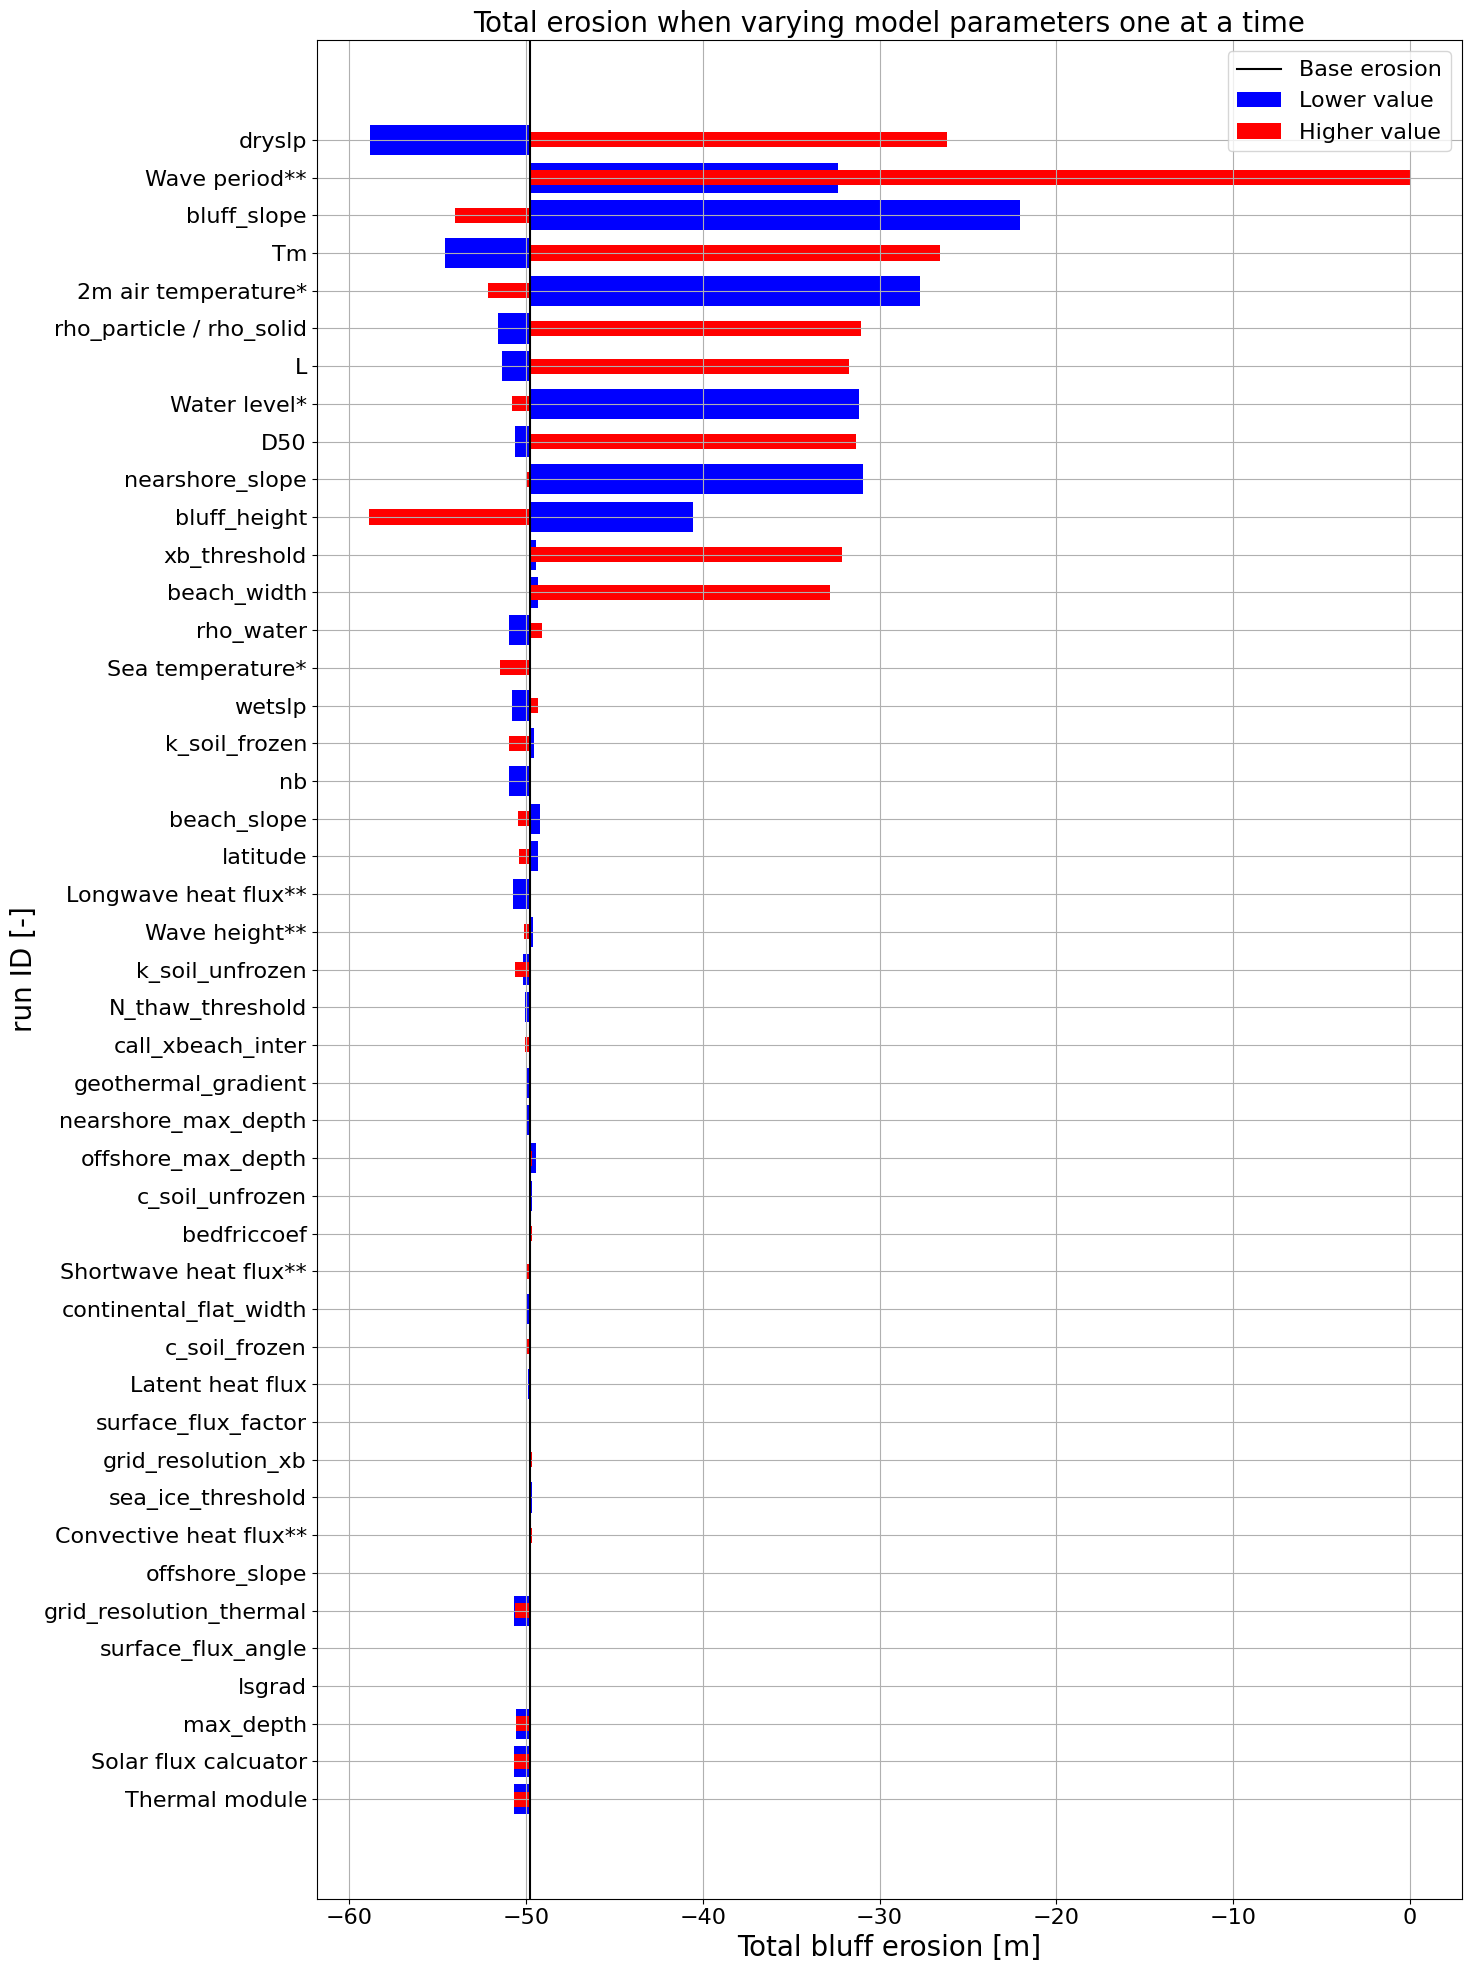

In [53]:
fig, ax = plt.subplots(figsize=(15, 20))

# x_left = total_bluff_erosion_base
x_left = volume_change_base

ax.barh(np.arange(len(df)), width=df['volume_change_low[m2]'].values - x_left, left=x_left, label='Lower value', color='b')
ax.barh(np.arange(len(df)), width=df['volume_change_high[m2]'].values - x_left, left=x_left, label='Higher value', color='r', height=0.4)
# ax.barh(np.arange(len(df)), width=df['total_erosion_low[m]'].values, left=x_left, fc=None, ec='k')
# ax.barh(np.arange(len(df)), width=df['total_erosion_low[m]'].values, left=x_left, fc=None, ec='k')


ax.axvline(x_left, color='k', label='Base erosion')

ax.set_yticks(np.arange(len(df)), df['varied_parameter'].values)

ax.grid()

ax.set_title('Total erosion when varying model parameters one at a time')

ax.legend()

ax.set_xlabel('Total bluff erosion [m]')
ax.set_ylabel('run ID [-]')

fig.tight_layout()

figname = 'SA_all.png'

fig.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

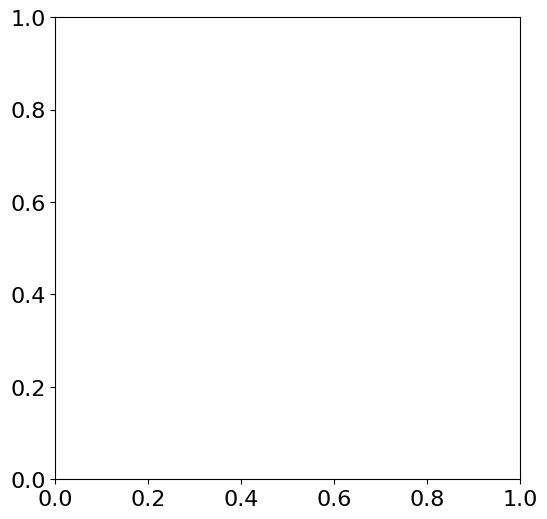

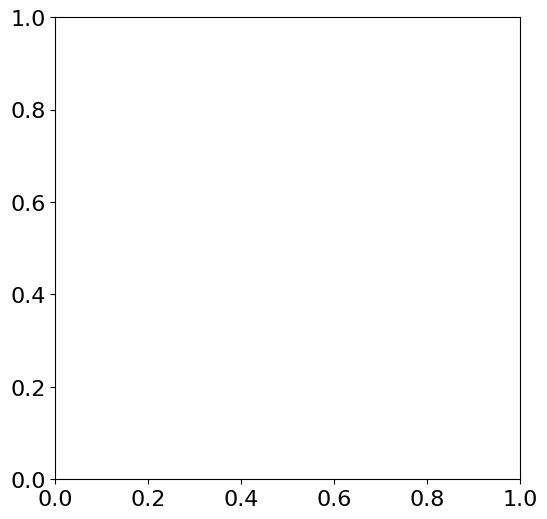

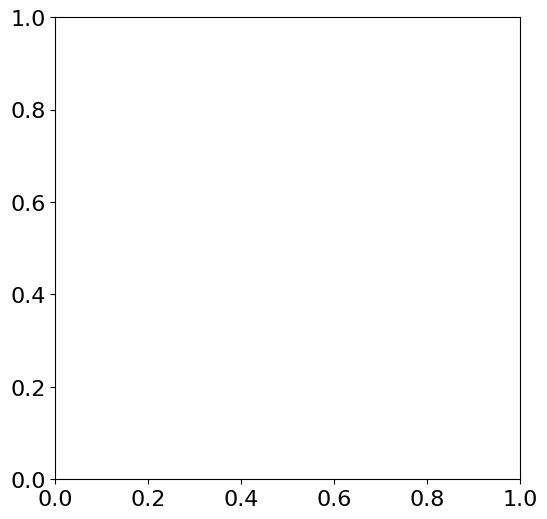

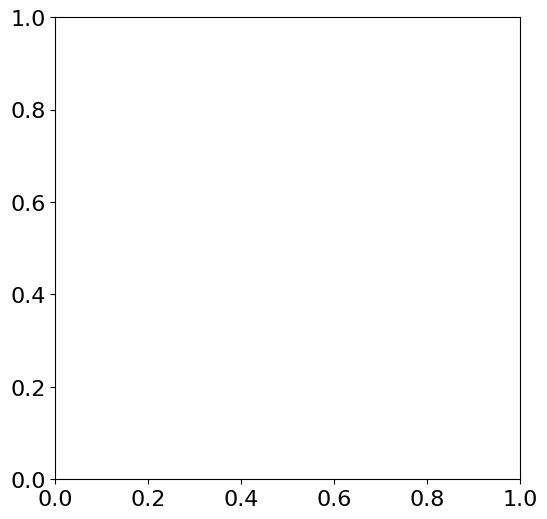

In [10]:
fig0, ax0 = plt.subplots(figsize=(6, 6))
fig1, ax1 = plt.subplots(figsize=(6, 6))
fig2, ax2 = plt.subplots(figsize=(6, 6))
fig3, ax3 = plt.subplots(figsize=(6, 6))

# fig, axs = plt.subplots(2,2, figsize=(6, 6))

df_bathy = df[df['sublevel']=='bathymetry']
df_model = df[df['sublevel']=='model']
df_physi = df[df['sublevel']=='physical']
df_envir = df[(df['sublevel']=='hydrodynamics') or df['sublevel']=='thermodynamics']
# df_therm = df[df['sublevel']=='thermodynamics']

x_left = total_bluff_erosion_base

ax0.barh(np.arange(len(df_bathy)), width=df_bathy['total_erosion_low[m]'].values, left=x_left, label='Low', color='b')
ax0.barh(np.arange(len(df_bathy)), width=df_bathy['total_erosion_high[m]'].values, left=x_left, label='High', color='r')

ax1.barh(np.arange(len(df_model)), width=df_model['total_erosion_low[m]'].values, left=x_left, label='Low', color='b')
ax1.barh(np.arange(len(df_model)), width=df_model['total_erosion_high[m]'].values, left=x_left, label='High', color='r')

ax2.barh(np.arange(len(df_physi)), width=df_physi['total_erosion_low[m]'].values, left=x_left, label='Low', color='b')
ax2.barh(np.arange(len(df_physi)), width=df_physi['total_erosion_high[m]'].values, left=x_left, label='High', color='r')

ax3.barh(np.arange(len(df_envir)), width=df_envir['total_erosion_low[m]'].values, left=x_left, label='Low', color='b')
ax3.barh(np.arange(len(df_envir)), width=df_envir['total_erosion_high[m]'].values, left=x_left, label='High', color='r')

# axs[1, 1].barh(np.arange(len(df_therm)), width=df_therm['total_erosion_low[m]'].values, left=x_left, label='thermo Low', color='y')
# axs[1, 1].barh(np.arange(len(df_therm)), width=df_therm['total_erosion_high[m]'].values, left=x_left, label='thermo High', color='g')

for ax in [ax0, ax1, ax2, ax3]:
    ax.axvline(x_left, color='k', label='base erosion')

    ax.grid()

    ax.legend()

    ax.set_xlabel('Total bluff erosion [m]')
    ax.set_ylabel('run ID [-]')

ax0.set_title('Bathymetry parameters')
ax1.set_title('Model parameters')
ax2.set_title('Physical parameters')
ax3.set_title('Environmental drivers')

ax0.set_xticks(np.arange(len(df_bathy)), df_bathy['run_id'].values)
ax1.set_xticks(np.arange(len(df_model)), df_bathy['run_id'].values)
ax2.set_xticks(np.arange(len(df_physi)), df_bathy['run_id'].values)
ax3.set_xticks(np.arange(len(df_envir)), df_bathy['run_id'].values)

fig0.tight_layout()
fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

figname0 = 'SA_ordered_bathy.png'
figname1 = 'SA_ordered_model.png'
figname2 = 'SA_ordered_physi.png'
figname3 = 'SA_ordered_envir.png'

fig0.savefig(os.path.join(save_path, figname0), bbox_inches='tight', facecolor='white', transparent=False)
fig1.savefig(os.path.join(save_path, figname1), bbox_inches='tight', facecolor='white', transparent=False)
fig2.savefig(os.path.join(save_path, figname2), bbox_inches='tight', facecolor='white', transparent=False)
fig3.savefig(os.path.join(save_path, figname3), bbox_inches='tight', facecolor='white', transparent=False)
